In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager

import os

import mplhep as hep
hep.set_style(hep.style.CMS)
hep.style.use("CMS")
# hep.style.use(usetex=True)

# import atlas_mpl_style as ampl
# ampl.use_atlas_style(usetex=True)
# ampl.set_color_cycle("Paper", 6)
import uproot
import glob
import awkward as ak

/tmp/ipykernel_276595/1438301588.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
# load the cms dataset
eosdir = '/local/d1/badea/tracker/data/smartpix/parquet/dataset12/unflipped'
cms = pd.DataFrame()
for f in os.listdir(eosdir):
    if 'recon' in f:
        continue
    cms = pd.concat([cms,pd.read_parquet(os.path.join(eosdir,f)),])
print(len(cms))
cms_pt = np.array(cms.pt)

7999482


In [89]:
# load the root files
files = "/local/d1/badea/tracker/smartpix/simulation/outdir/cmsMatch/10/*.root"
tree = "Delphes"
delphes_track_pt = []
delphes_particle_pt = []
branches = ["Track.PT", "Track.PID", "Particle.PT", "Particle.Status", "Particle.PID"]
pionPID = 211 # plus/minus
for array in uproot.iterate(f"{files}:{tree}", branches):
    
    # track pt
    pt = np.array(ak.flatten(array[branches[0]]))
    pid = np.array(ak.flatten(array[branches[1]]))
    delphes_track_pt.append(pt[(abs(pid)==pionPID)])

    # particle pt
    p_pt = np.array(ak.flatten(array[branches[2]]))
    status = np.array(ak.flatten(array[branches[3]]))
    pid = np.array(ak.flatten(array[branches[4]]))
    delphes_particle_pt.append(p_pt[(status==1) * (abs(pid)==pionPID)])

delphes_track_pt = np.array(np.concatenate(delphes_track_pt))
delphes_particle_pt = np.array(np.concatenate(delphes_particle_pt))
print(delphes_track_pt.shape, delphes_particle_pt.shape)

(1578635,) (9635422,)


pT_density_NominalDelphesCMS.pdf


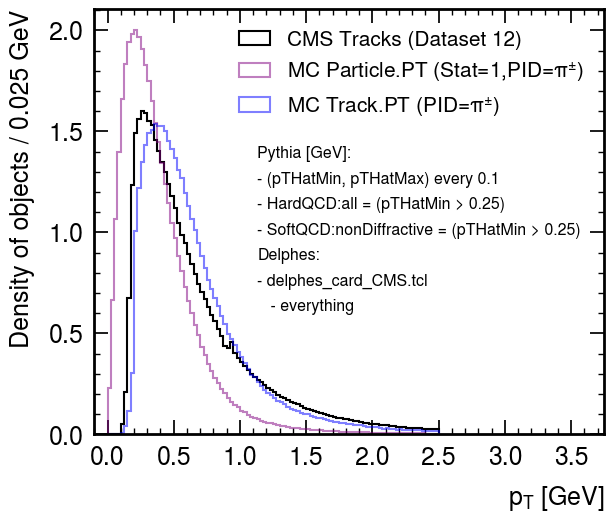

In [90]:
# make plot
fig = plt.figure(figsize=(6, 5))
ax = plt.axes([0.1, 0.1, 0.85, 0.85])

# settings
lw=1.5
rasterized = False
density = True
xlog = False
ylog = False
nominalDelphesCMS = True
bins = np.linspace(0,2.5,101)
bw = bins[1]-bins[0]

# draw data
ax.hist(cms_pt, 
        bins=bins,
        alpha=1.0, 
        lw=lw,
        ls="-",
        histtype="step",
        label="CMS Tracks (Dataset 12)",
        color="black",
        density=density,
        rasterized=rasterized)
# draw particle simulation
ax.hist(delphes_particle_pt, 
        bins=bins,
        alpha=0.5, 
        lw=lw,
        ls="-",
        histtype="step",
        label=f"MC {branches[2]}" r" (Stat=1,PID=$\pi^{\pm}$)",
        color="purple",
        density=density,
        rasterized=rasterized)
# draw track simulation
ax.hist(delphes_track_pt, 
        bins=bins,
        alpha=0.5, 
        lw=lw,
        ls="-",
        histtype="step",
        label=f"MC {branches[0]}" r" (PID=$\pi^{\pm}$)",
        color="blue",
        density=density,
        rasterized=rasterized)

# set labels
ax.set_xlabel("p$_{T}$ [GeV]", fontsize=18, labelpad=9, horizontalalignment='right', x=1.0)
ax.set_ylabel(("Density of objects" if density else "Number of objects")+f" / {bw} GeV", fontsize=18, labelpad=9, horizontalalignment='right', y=1.0)

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 18,
                     "pad"       : 8}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 15}

# ax.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(**tick_params_major)
ax.tick_params(**tick_params_minor)
plt.locator_params(axis='y', nbins=8)
plt.locator_params(axis='x', nbins=8)

# ax.ticklabel_format(axis='y', style='sci')
plt.ticklabel_format(axis='y', style='sci', scilimits=(1,2), useMathText=True)

# set limits and scale
if xlog == True:
    ax.set_xlim(5*10**-2, 5)
    plt.xscale("log")
else:
    ax.set_xlim(-0.1, 3.75)
if ylog == True:
    plt.yscale("log")
# ax.set_ylim(0, 2.6)

plt.legend(fontsize=15)

# stamps
left, top, t = 0.32, 0.68, 0.06
stamps = [
    "Pythia [GeV]:",
    "- (pTHatMin, pTHatMax) every 0.1",
    "- HardQCD:all = (pTHatMin > 0.25)",
    "- SoftQCD:nonDiffractive = (pTHatMin > 0.25)",
    "Delphes:",
    # "- CMS_PhaseII_0PU.tcl",
    # "   - ChargedHadronTrackingEfficiency",
    "- delphes_card_CMS.tcl",
    "   - everything" # else"
]
for i, stamp in enumerate(stamps):
    plt.text(left, top - i*t, stamp, fontsize=11.5, ha='left', va='top', transform=plt.gca().transAxes)


# output name
outFileName = "pT" 
outFileName += ("_density" if density else "") 
outFileName += ("_xlog" if xlog else "")
outFileName += ("_ylog" if ylog else "")
outFileName += ("_NominalDelphesCMS" if nominalDelphesCMS else "")
outFileName += ".pdf"
print(outFileName)
# plt.savefig(outFileName, bbox_inches="tight")

